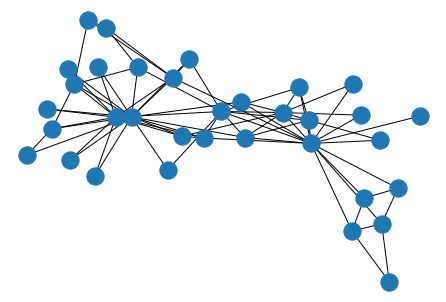

In [1]:
# Create a graph
import networkx as nx
G = nx.karate_club_graph()

# Visualize the graph, for fun
import matplotlib.pyplot as plt
nx.draw(G)

In [2]:
import gurobipy as gp
from gurobipy import GRB

# solve maximum k-club problem, with
k = 3

In [3]:
# Create model object
m = gp.Model()

# Create variable for each node
x = m.addVars( G.nodes, vtype=GRB.BINARY )

# Objective function: maximize number of nodes
m.setObjective( gp.quicksum( x[i] for i in G.nodes ), GRB.MAXIMIZE )

# Initial constraints: don't pick nodes i and j when dist(i,j) > k
for i in G.nodes:
    dist = nx.shortest_path_length(G, source=i)
    for j in G.nodes:
        if dist[j] > k and i < j:
            m.addConstr( x[i] + x[j] <= 1 )

m._G = G
m._k = k
m._x = x
m.update()

Academic license - for non-commercial use only - expires 2021-07-26
Using license file C:\Users\Austin\gurobi.lic


In [4]:
# Add (violated) length-bounded cut constraints in a callback routine
def lcut_callback(m, where):
    
    # check if LP relaxation at this BB node is integer
    if where == GRB.Callback.MIPSOL: 
        
        # retrieve the LP relaxation solution at this BB node
        xval = m.cbGetSolution(m._x)
        
        # which nodes are selected in the LP solution?
        chosen_nodes = [ i for i in m._G.nodes if xval[i] > 0.5 ]
        
        # if G[chosen_nodes] is not a k-club, then 
        #   find nodes a and b with dist_{G[chosen_nodes]} (a,b) > k
        #   as well as a minimal length-k cut C from V \ (chosen_nodes)
        #   and add constraint x[a] + x[b] <= 1 + x(C).     
        
        for a in chosen_nodes:
            
            dist_a = nx.shortest_path_length( G.subgraph(chosen_nodes), source=a )

            for b in chosen_nodes:
                
                if a<b and (b not in dist_a.keys() or dist_a[b] > k):
                    
                    # We've found nodes a and b with dist_{G[chosen_nodes]} (a,b) > k
                    C = [ i for i in m._G.nodes if xval[i] < 0.5 ]
                    VminusC = [ i for i in m._G.nodes if xval[i] > 0.5 ]
                    
                    # make C minimal, i.e., make VminusC maximal
                    for c in C:
                        VminusC.append(c)
                        
                        dist_b = nx.shortest_path_length( G.subgraph(VminusC), source=b)
                        
                        if dist_b[a] <= k:
                            VminusC.pop()
                        
                    minC = [ i for i in m._G.nodes if i not in VminusC ]
                    m.cbLazy( x[a] + x[b] <= 1 + gp.quicksum( m._x[i] for i in minC ) )

In [5]:
# Tell Gurobi that we will be adding (lazy) constraints
m.Params.lazyConstraints = 1

# Designate the callback routine to be the function "lcut_callback"
m._callback = lcut_callback

# Solve the MIP with our callback
m.optimize(m._callback)

Changed value of parameter lazyConstraints to 1
   Prev: 0  Min: 0  Max: 1  Default: 0
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (win64)
Thread count: 2 physical cores, 4 logical processors, using up to 4 threads
Optimize a model with 81 rows, 34 columns and 162 nonzeros
Model fingerprint: 0x06e51652
Variable types: 0 continuous, 34 integer (34 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+00]
Found heuristic solution: objective 25.0000000
Presolve time: 0.00s
Presolved: 81 rows, 34 columns, 162 nonzeros
Variable types: 0 continuous, 34 integer (34 binary)

Root relaxation: cutoff, 0 iterations, 0.00 seconds

Explored 0 nodes (0 simplex iterations) in 0.12 seconds
Thread count was 4 (of 4 available processors)

Solution count 1: 25 

Optimal solution found (tolerance 1.00e-04)
Best objective 2.500000000000e+01, best bound 2.500000000000e+01, gap 0.0000%

User-callb

In [6]:
print("Objective:",m.objVal)

selected_nodes = [ i for i in G.nodes if x[i].x > 0.5 ]

print("Selected nodes:", selected_nodes)

Objective: 25.0
Selected nodes: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 17, 19, 21, 24, 25, 27, 28, 30, 31, 32, 33]


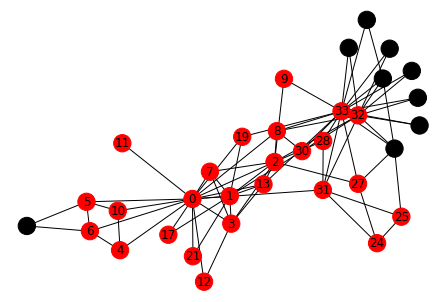

In [7]:
# Visualize the solution
node_colors = [ "red" if i in selected_nodes else "black" for i in G.nodes ]

nx.draw( G, with_labels=True, node_color=node_colors )

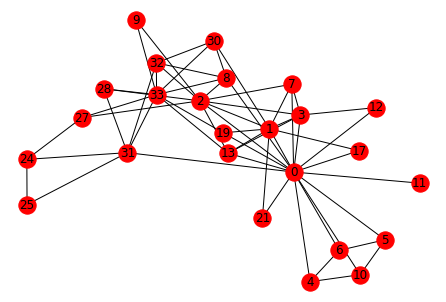

In [8]:
nx.draw( G.subgraph(selected_nodes), with_labels=True, node_color="red")